بالبداية سنقوم باستيراد المكاتب التي سنعمل عليها

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Model,Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
import pandas as pd

لدينا مجموعتي التدريب و الاختبار سنقوم قرائتها عن طريق التابع الذي يقرأ من ملف الاكسل

In [2]:
test = pd.read_csv('mitbih_test.csv',header=None)
train = pd.read_csv('mitbih_train.csv',header=None)

In [3]:
print(test.info())
print("********************")
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB
None
********************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB
None


سنقوم برسم مخطط شارت باي لرؤية انواع الداتا و نسبة كل صنف بالداتاسيت

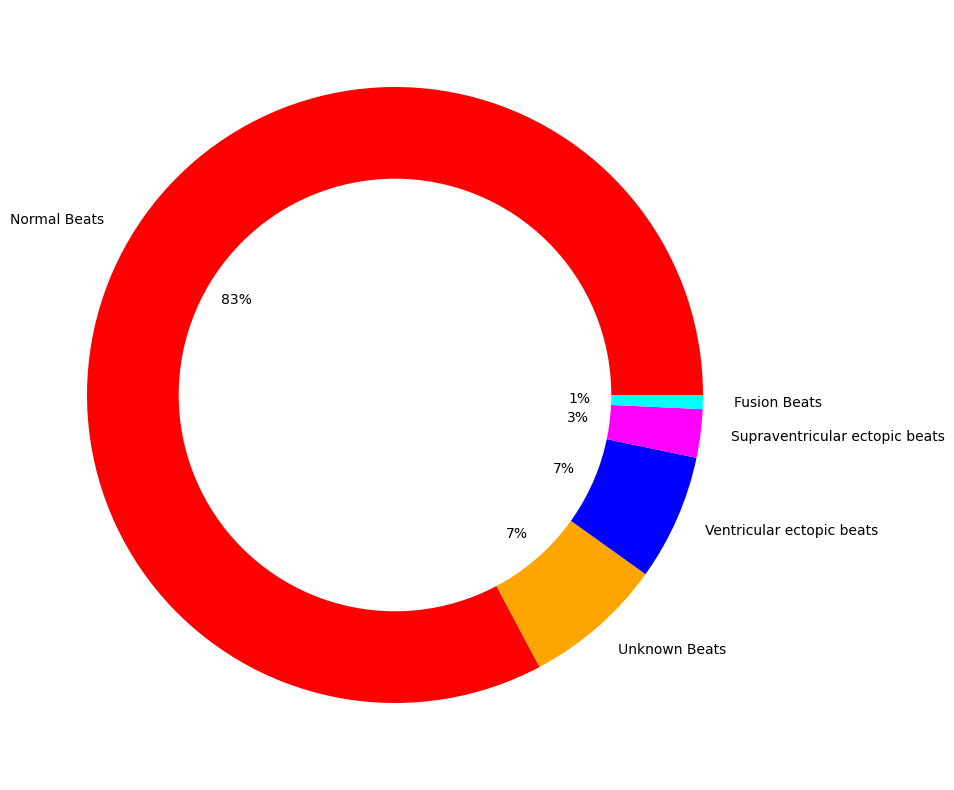

In [4]:
plt.figure(figsize= (10,10))
my_circle = plt.Circle((0,0), 0.7, color = 'white') 
plt.pie(train[187].value_counts(), labels=['Normal Beats','Unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats',
                                                'Fusion Beats'], autopct = '%0.0f%%', colors = ['red','orange','blue','magenta','cyan'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

الان سنقوم بفصل الداتا في متحولات و ذلك لاختيار عدد معين من كل صنف للتدريب عليه

In [6]:
df_1 = train[train[187] == 1]
df_2 = train[train[187] == 2]
df_3 = train[train[187] == 3]
df_4 = train[train[187] == 4]

مرحلة السامبل
سنقوم بأخذ عدد معين من كل صنف لتدريب الشبكة عليه و ذلك لجعل الشبكة تتدرب على كل الانواع بشكل متساوي و جعل المودل غير منحاز لصنف معين
و في النهاية سنقوم بجمع هذه العينات مرة اخرى و ستكون هي الداتا التي سيتدرب عليها المودل

In [9]:
from sklearn.utils import resample

df_1_upsample = resample(df_1, n_samples = 20000, replace = True, random_state = 123)
df_2_upsample = resample(df_2, n_samples = 20000, replace = True, random_state = 123)
df_3_upsample = resample(df_3, n_samples = 20000, replace = True, random_state = 123)
df_4_upsample = resample(df_4, n_samples = 20000, replace = True, random_state = 123)
df_0 = train[train[187]==0].sample(n =20000, random_state=123)
train_df = pd.concat([df_0, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

سنعيد رسم مخطط الشارت باي لرؤية النتيجة بعد التقسيم 

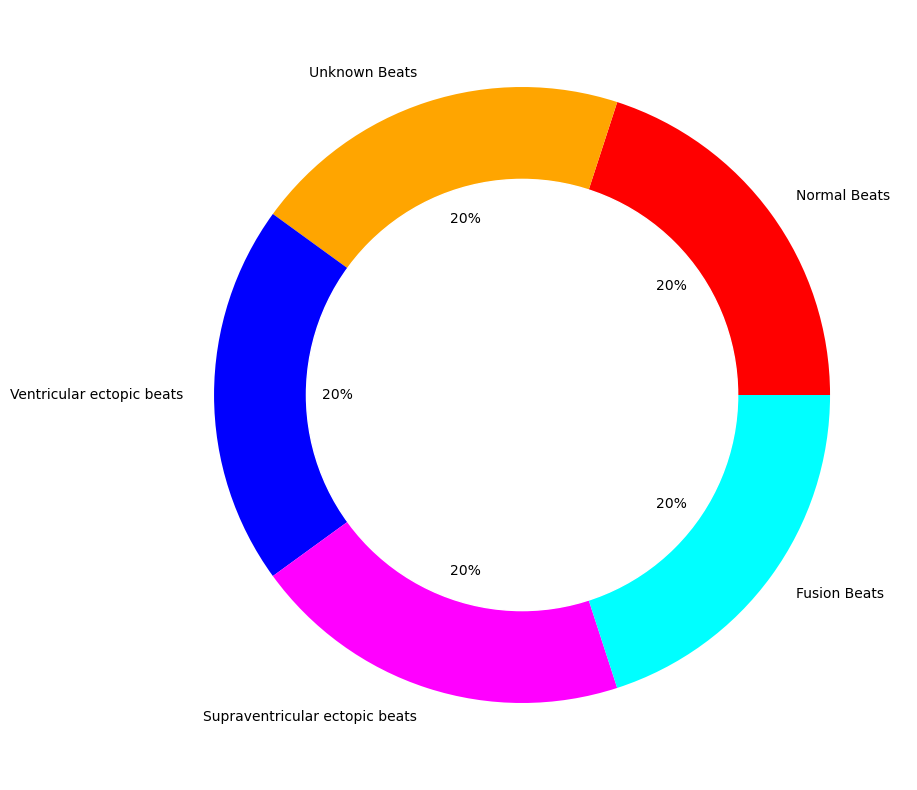

In [10]:
plt.figure(figsize= (10,10))
my_circle = plt.Circle((0,0), 0.7, color = 'white') 
plt.pie(train_df[187].value_counts(), labels=['Normal Beats','Unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats',
                                                'Fusion Beats'], autopct = '%0.0f%%', colors = ['red','orange','blue','magenta','cyan'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

ان مجموعة التدريب تحوي على خمسة انواع من الاصنتف و العامود الاخير يدل على صنف كل عينة حيث رمزنا لكل عينا بالاندكس[0,1,2,3,4] 
و من ثم قمنا بتقسيم الداتا سيت لهذه الاقسام الخمسة و جمعها في مصفوفة واحدة

In [11]:
from keras.utils import to_categorical
trainX = train_df.loc[:,train_df.columns!=187]
trainY = train_df.loc[:,train_df.columns==187]
trainY = to_categorical(trainY)
testX = test.loc[:,test.columns!=187]
testY = test.loc[:,test.columns==187]
testY = to_categorical(testY)

In [12]:
print (testX.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 187 entries, 0 to 186
dtypes: float64(187)
memory usage: 31.2 MB
None


و الأن سنقوم ببناء الشبكة و ي تتكون من ثلاث طبقات في الطبقة 100 عصبون و الثانية 100 عصبون و الثالثة 5 (يعبر عن عدد التصنيفات التي تحاول الشبكة التنبأ بها) و هي طبقات كاملة الاتصال اي كل عصبونات طبقة تتصل بالعصبونات الطبقة التي تليها بشكل كامل 
في الطبقة الاولى و الثانية قمنا باستخدام تابع ريلو كتابع تفعيل و ذلك لأنه تابع اثبت فعاليته في الطبقات المخفية 
و في الطبقة الاخير استخدمنا تابع سوفت ماكس الذي سيقوم بتحويل النتيجة لنسبة احتمالية و هو امر مهمة في مسالة التصنيف لدينا

In [15]:
# بالبداية قمنا بتعريف بنية الشبكة
model = Sequential()
#نضيف الطبقات كما شرحناها
model.add(Dense(187,activation='relu' , input_shape=(187,)))
model.add(Dense(100 , activation='relu'))
model.add(Dense(5,activation='softmax'))
"""
و في هذه المرحلة سنقوم بعمل كومبايل للشبكة و بنائها 
البرامتات:
optimizer = 'Adam': و ذلك لأنه يعتمد على تغيير عامل التعلم في كل عينة و بالتالي القدرة على التعلم من المعلومات بشكل افضل
loss = 'categorical_crossentropy': هذا التابع مناسب جداً لمسائل التصنيف  حيث يقوم بالمقارنة بين القيمة الاحتمالية المتوقعة و القيمة الاحتمالية الصحيحة
metrics = ['accuracy']: حيث انه هذا العامل يحاول رفع دقة المودل بالتوقع
"""
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
"""
سنقوم الأن بتدريب الشبكة 
بالبداية سسنمرر العينات مع التوقع الخاص بها 
و سنقوم بتحديد 100 جيل للتدريب
سنقوم بتعيين باتش ب 128 ليكون التعليم بشكل دقيق اكثر
سنقوم باعطاء المودل مجموعة الاختبار و ذلك لتقييم المودل بعد كل عصر تدريب  و هذا سيزيد من اداء الشبكة في التدريب
"""
his = model.fit(trainX , trainY ,
                batch_size=128,
                validation_data=(testX , testY) ,
                epochs=100 , verbose=True)
print('evaloution: ' )
# للتأكد من أن المودل سيقوم بالعمل بنسبة جيدة على الداتا الجديدة سنرى نسبة الدقة عند اختباره على داتا التجريب و سيعيد قيمتين الاولى تعبر عن اللوس و القيمة الثانية تعبر عن الدقة
loss , acc = model.evaluate(testX , testY)
print('loss:' , loss)
print('accuracy: ' , acc)

Epoch 1/100
782/782 [==============================] - 2s 3ms/step - loss: 0.4638 - accuracy: 0.8318 - val_loss: 0.5406 - val_accuracy: 0.7911
Epoch 2/100
782/782 [==============================] - 2s 2ms/step - loss: 0.2622 - accuracy: 0.9046 - val_loss: 0.3468 - val_accuracy: 0.8669
Epoch 3/100
782/782 [==============================] - 2s 2ms/step - loss: 0.2032 - accuracy: 0.9284 - val_loss: 0.2753 - val_accuracy: 0.9067
Epoch 4/100
782/782 [==============================] - 2s 2ms/step - loss: 0.1643 - accuracy: 0.9427 - val_loss: 0.2399 - val_accuracy: 0.9149
Epoch 5/100
782/782 [==============================] - 2s 2ms/step - loss: 0.1388 - accuracy: 0.9527 - val_loss: 0.2370 - val_accuracy: 0.9186
Epoch 6/100
782/782 [==============================] - 2s 3ms/step - loss: 0.1196 - accuracy: 0.9601 - val_loss: 0.1876 - val_accuracy: 0.9408
Epoch 7/100
782/782 [==============================] - 2s 2ms/step - loss: 0.1035 - accuracy: 0.9661 - val_loss: 0.2245 - val_accuracy: 0.9292

Epoch 58/100
782/782 [==============================] - 2s 2ms/step - loss: 0.0102 - accuracy: 0.9971 - val_loss: 0.2326 - val_accuracy: 0.9627
Epoch 59/100
782/782 [==============================] - 2s 3ms/step - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.2573 - val_accuracy: 0.9544
Epoch 60/100
782/782 [==============================] - 2s 3ms/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.2272 - val_accuracy: 0.9626
Epoch 61/100
782/782 [==============================] - 2s 3ms/step - loss: 0.0135 - accuracy: 0.9960 - val_loss: 0.2383 - val_accuracy: 0.9603
Epoch 62/100
782/782 [==============================] - 2s 3ms/step - loss: 0.0102 - accuracy: 0.9969 - val_loss: 0.2121 - val_accuracy: 0.9687
Epoch 63/100
782/782 [==============================] - 2s 3ms/step - loss: 0.0127 - accuracy: 0.9961 - val_loss: 0.2562 - val_accuracy: 0.9578
Epoch 64/100
782/782 [==============================] - 2s 3ms/step - loss: 0.0123 - accuracy: 0.9962 - val_loss: 0.2164 - val_accuracy:

الأن سنقوم برسم قيم اللوس و قيم الاكيورسي و التغيير الذي حصل على قيمهما خلال التدريب 
سنرسم خطين بيانين يدلان على تغيير هذه القيم خلال الحقب

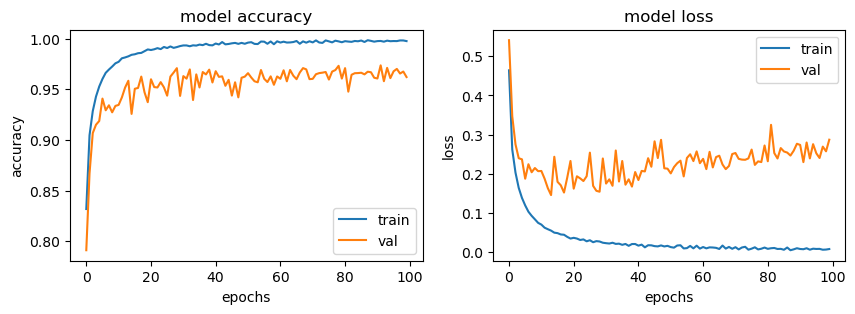

In [16]:
fig , ax= plt.subplots(1,2,figsize=(10,3))
for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(his.history[met])
    ax[i].plot(his.history['val_' + met])
    ax[i].set_title('model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train' , 'val'])
plt.show()